<a href="https://colab.research.google.com/github/Deekshitha004/Network-Intrusion-Detection-System/blob/main/AutoML_Online_Learning_Dataset_1(online).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score, precision_score, recall_score, f1_score
import lightgbm as lgb
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from scipy.stats import shapiro
from imblearn.over_sampling import SMOTE
import time

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
!pip uninstall pandas -y

Found existing installation: pandas 1.3.5
Uninstalling pandas-1.3.5:
  Successfully uninstalled pandas-1.3.5


In [ ]:
!pip install pandas==2.0.3

  Using cached pandas-2.0.3-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (12.3 MB)


In [ ]:
import pandas as pd

In [ ]:
df = pd.read_csv("/content/cic_0.01km.csv")

In [ ]:
df

,Flow Duration,Total Length of Fwd Packets,Fwd Packet Length Max,Fwd Packet Length Mean,Bwd Packet Length Max,Bwd Packet Length Min,Flow IAT Mean,Flow IAT Min,Fwd IAT Min,Fwd Header Length,Bwd Header Length,Fwd Packets/s,Bwd Packets/s,Min Packet Length,URG Flag Count,Down/Up Ratio,Init_Win_bytes_forward,Init_Win_bytes_backward,min_seg_size_forward,Labelb
0,50833,0,0,0.0000,0,0,5.083300e+04,50833,0,32,32,19.672260,19.672260,0,1,1,319,153,32,0
1,49,0,0,0.0000,0,0,4.900000e+01,49,49,64,0,40816.326530,0.000000,0,0,0,277,-1,32,0
2,306,6,6,6.0000,6,6,3.060000e+02,306,0,20,20,3267.973856,3267.973856,6,0,1,0,0,20,0
3,63041,65,65,65.0000,124,124,6.304100e+04,63041,0,32,32,15.862693,15.862693,65,0,1,-1,-1,32,0
4,47682,43,43,43.0000,59,59,4.768200e+04,47682,0,32,32,20.972275,20.972275,43,0,1,-1,-1,32,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28298,45,0,0,0.0000,0,0,4.500000e+01,45,0,32,32,22222.222220,22222.222220,0,1,1,349,307,32,0
28299,114309573,511,427,31.9375,746,0,3.941709e+06,94,165,332,424,0.139971,0.122474,0,0,0,8192,343,20,0
28300,48850,80,40,40.0000,72,72,1.628333e+04,1,48,64,64,40.941658,40.941658,40,0,1,-1,-1,32,0
28301,260,66,33,33.0000,97,97,8.666667e+01,48,48,40,40,7692.307692,7692.307692,33,0,1,-1,-1,20,0


In [ ]:
df.columns


Index(['Flow Duration', 'Total Length of Fwd Packets', 'Fwd Packet Length Max',
       'Fwd Packet Length Mean', 'Bwd Packet Length Max',
       'Bwd Packet Length Min', 'Flow IAT Mean', 'Flow IAT Min', 'Fwd IAT Min',
       'Fwd Header Length', 'Bwd Header Length', 'Fwd Packets/s',
       'Bwd Packets/s', 'Min Packet Length', 'URG Flag Count', 'Down/Up Ratio',
       'Init_Win_bytes_forward', 'Init_Win_bytes_backward',
       'min_seg_size_forward', 'Labelb'],
      dtype='object')

In [ ]:
df.columns=['Flow Duration', 'Total Length of Fwd Packets', 'Fwd Packet Length Max',
       'Fwd Packet Length Mean', 'Bwd Packet Length Max',
       'Bwd Packet Length Min', 'Flow IAT Mean', 'Flow IAT Min', 'Fwd IAT Min',
       'Fwd Header Length', 'Bwd Header Length', 'Fwd Packets/s',
       'Bwd Packets/s', 'Min Packet Length', 'URG Flag Count', 'Down/Up Ratio',
       'Init_Win_bytes_forward', 'Init_Win_bytes_backward',
       'min_seg_size_forward', 'Label']

In [ ]:
# Define the automated data encoding function
def Auto_Encoding(df):
    cat_features=[x for x in df.columns if df[x].dtype=="object"] ## Find string/text features
    le=LabelEncoder()
    for col in cat_features:
        if col in df.columns:
            i = df.columns.get_loc(col)
            # Transform to numerical features
            df.iloc[:,i] = df.apply(lambda i:le.fit_transform(i.astype(str)), axis=0, result_type='expand')
    return df

In [ ]:
df=Auto_Encoding(df)

In [ ]:
# Define the automated data imputation function
def Auto_Imputation(df):
    if df.isnull().values.any() or np.isinf(df).values.any(): # if there is any empty or infinite values
        df.replace([np.inf, -np.inf], np.nan, inplace=True)
        df.fillna(0, inplace = True)  # Replace empty values with zeros; there are other imputation methods discussed in the paper
    return df

In [ ]:
df=Auto_Imputation(df)

## Automated normalization
Normalize the range of features to a similar scale to improve data quality

In [ ]:
def Auto_Normalization(df):
    stat, p = shapiro(df)
    print('Statistics=%.3f, p=%.3f' % (stat, p))
    # interpret
    alpha = 0.05
    numeric_features = df.drop(['Label'],axis = 1).dtypes[df.dtypes != 'object'].index

    # check if the data distribution follows a Gaussian/normal distribution
    # If so, select the Z-score normalization method; otherwise, select the min-max normalization
    # Details are in the paper
    if p > alpha:
        print('Sample looks Gaussian (fail to reject H0)')
        df[numeric_features] = df[numeric_features].apply(
            lambda x: (x - x.mean()) / (x.std()))
        print('Z-score normalization is automatically chosen and used')
    else:
        print('Sample does not look Gaussian (reject H0)')
        df[numeric_features] = df[numeric_features].apply(
            lambda x: (x - x.min()) / (x.max()-x.min()))
        print('Min-max normalization is automatically chosen and used')
    return df

In [ ]:
df=Auto_Normalization(df)

Statistics=0.076, p=0.000
Sample does not look Gaussian (reject H0)
Min-max normalization is automatically chosen and used


# 2. Automated Feature Engineering
Feature selection method 1: **Information Gain (IG)**, used to remove irrelevant features to improve model efficiency  
Feature selection method 2: **Pearson Correlation**, used to remove redundant features to improve model efficiency and accuracy  

In [ ]:
# Remove irrelevant features and select important features
def Feature_Importance_IG(data):
    features = data.drop(['Label'],axis=1).values  # "Label" should be changed to the target class variable name if different
    labels = data['Label'].values

    # Extract feature names
    feature_names = list(data.drop(['Label'],axis=1).columns)

    # Empty array for feature importances
    feature_importance_values = np.zeros(len(feature_names))
    model = lgb.LGBMRegressor(verbose = -1)
    model.fit(features, labels)
    feature_importances = pd.DataFrame({'feature': feature_names, 'importance': model.feature_importances_})

    # Sort features according to importance
    feature_importances = feature_importances.sort_values('importance', ascending = False).reset_index(drop = True)

    # Normalize the feature importances to add up to one
    feature_importances['normalized_importance'] = feature_importances['importance'] / feature_importances['importance'].sum()
    feature_importances['cumulative_importance'] = np.cumsum(feature_importances['normalized_importance'])

    cumulative_importance=0.90 # Only keep the important features with cumulative importance scores>=90%. It can be changed.

    # Make sure most important features are on top
    feature_importances = feature_importances.sort_values('cumulative_importance')

    # Identify the features not needed to reach the cumulative_importance
    record_low_importance = feature_importances[feature_importances['cumulative_importance'] > cumulative_importance]

    to_drop = list(record_low_importance['feature'])
#     print(feature_importances.drop(['importance'],axis=1))
    return to_drop

In [ ]:
def Feature_Redundancy_Pearson(data):
    correlation_threshold = 0.90
    features = data.drop(['Label'], axis=1)
    corr_matrix = features.corr()
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    to_drop = [column for column in upper.columns if any(upper[column].abs() > correlation_threshold)]

    return to_drop

In [ ]:
def Auto_Feature_Engineering(df):
    drop1 = Feature_Importance_IG(df)
    dfh1 = df.drop(columns=drop1)

    drop2 = Feature_Redundancy_Pearson(dfh1)
    dfh2 = dfh1.drop(columns=drop2)

    return dfh2

In [ ]:
dfh2 = Auto_Feature_Engineering(df)
dfh2

,Flow Duration,Total Length of Fwd Packets,Fwd Packet Length Max,Fwd Packet Length Mean,Bwd Packet Length Max,Flow IAT Mean,Flow IAT Min,Fwd IAT Min,Fwd Header Length,Bwd Packets/s,Init_Win_bytes_forward,Init_Win_bytes_backward,Label
0,4.236419e-04,0.000000,0.000000,0.000000,0.000000,4.707129e-04,4.707129e-04,0.000000e+00,0.000150,1.311484e-05,0.004883,0.002350,0
1,4.416669e-07,0.000000,0.000000,0.000000,0.000000,4.907407e-07,4.907407e-07,4.083333e-07,0.000299,0.000000e+00,0.004242,0.000000,0
2,2.583334e-06,0.000008,0.000242,0.001556,0.000516,2.870370e-06,2.870370e-06,0.000000e+00,0.000094,2.178649e-03,0.000015,0.000015,0
3,5.253752e-04,0.000090,0.002619,0.016856,0.010660,5.837500e-04,5.837500e-04,0.000000e+00,0.000150,1.057513e-05,0.000000,0.000000,0
4,3.973835e-04,0.000060,0.001732,0.011151,0.005072,4.415370e-04,4.415370e-04,0.000000e+00,0.000150,1.398152e-05,0.000000,0.000000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
28298,4.083335e-07,0.000000,0.000000,0.000000,0.000000,4.537037e-07,4.537037e-07,0.000000e+00,0.000150,1.481481e-02,0.005341,0.004700,0
28299,9.525802e-01,0.000710,0.017204,0.008282,0.064133,3.649735e-02,9.074074e-07,1.375000e-06,0.001554,8.164962e-08,0.125015,0.005249,0
28300,4.071168e-04,0.000111,0.001612,0.010373,0.006190,1.508086e-04,4.629629e-08,4.000000e-07,0.000299,2.729444e-05,0.000000,0.000000,0
28301,2.200001e-06,0.000092,0.001330,0.008558,0.008339,8.395061e-07,4.814815e-07,4.000000e-07,0.000187,5.128205e-03,0.000000,0.000000,0


In [ ]:
a=dfh2.columns

In [ ]:
type(dfh2)

pandas.core.frame.DataFrame

In [ ]:
dfh2.to_csv('output_data.csv', index=False)

## Train-test split
Split the dataset into the training and the test set   

Here we used the 1%/99% split, because for online learning, the initial available data would only be a small percentage, and the incoming data streams will be continously learned by the data analytics models. It can be changed based on specific tasks

In [ ]:
X = dfh2.drop(['Label'],axis=1)
y = dfh2['Label']

X_train, X_test, y_train, y_test = train_test_split(X,y, train_size = 0.01, test_size = 0.99, shuffle=False,random_state = 0)

## Automated data balancing
Generate minority class samples to solve class-imbalance and improve data quality.  
Synthetic Minority Over-sampling Technique (SMOTE) method is used.

In [ ]:
pd.Series(y_train).value_counts()

Label
0    180
1    103
Name: count, dtype: int64

In [ ]:
from imblearn.over_sampling import SMOTE

In [ ]:
def Auto_Balancing(X_train, y_train):
    number0 = pd.Series(y_train).value_counts().iloc[0]
    number1 = pd.Series(y_train).value_counts().iloc[1]

    if number0 > number1:
        nlarge = number0
    else:
        nlarge = number1

    # evaluate whether the incoming dataset is imbalanced (the abnormal/normal ratio is smaller than a threshold (e.g., 50%))
    if (number1/number0 > 1.5) or (number0/number1 > 1.5):
        smote=SMOTE(n_jobs=-1,sampling_strategy={0:nlarge, 1:nlarge})
        X_train, y_train = smote.fit_resample(X_train, y_train)

    return X_train, y_train

In [ ]:
!pip install imbalanced-learn
from imblearn.over_sampling import SMOTE

In [ ]:
X_train, y_train = Auto_Balancing(X_train, y_train)

In [ ]:
pd.Series(y_train).value_counts()

Label
0    180
1    180
Name: count, dtype: int64

# 3. Model Learning

Four state-of-the-art online learners:
* Hoeffding Tree (HT)
* Leveraging Bagging (LB)
* Adaptive Random Forest (ARF)
* Streaming Random Patches (SRP)


An offline learner for comparison:
* LightGBM


## Static Model learning: LightGBM (for Comparison)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 180, number of negative: 180
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000121 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 712
[LightGBM] [Info] Number of data points in the train set: 360, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits

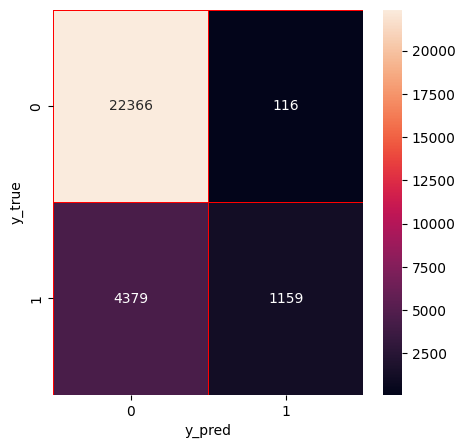

CPU times: user 694 ms, sys: 114 ms, total: 809 ms
Wall time: 1.07 s


In [ ]:
%%time
# LightGBM algorithm
import lightgbm as lgb
classifier = lgb.LGBMClassifier()
classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test)
print(classification_report(y_test,y_pred))
print("Accuracy: "+str(round(accuracy_score(y_test, y_pred),5)*100)+"%")
print("Precision: "+str(round(precision_score(y_test, y_pred),5)*100)+"%")
print("Recall: "+str(round(recall_score(y_test, y_pred),5)*100)+"%")
print("F1-score: "+str(round(f1_score(y_test, y_pred),5)*100)+"%")

# Plot the confusion matrix
cm=confusion_matrix(y_test,y_pred)
f,ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

The accuracy of the static LightGBM model is very low (83.958%), due to the occurance of concept drift (data distribution changes). Therefore, online learning methods that can adapt to concept drift issues should be developed for dynamic data stream analytics.

## Online Learning

In [ ]:
!pip show river

In [ ]:
!pip install river

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 7.9 MB/s eta 0:00:00
  Using cached pandas-2.2.2-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (13.0 MB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 28.8/28.8 MB 22.4 MB/s eta 0:00:00
  Attempting uninstall: polars
    Found existing installation: polars 0.20.2
    Uninstalling polars-0.20.2:
      Successfully uninstalled polars-0.20.2
  Attempting uninstall: pandas
    Found existing installation: pandas 2.0.3
    Uninstalling pandas-2.0.3:
      Successfully uninstalled pandas-2.0.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 24.4.1 requires pandas<2.2.2dev0,>=2.0, but you have pandas 2.2.2 which is incompatible.
google-colab 1.0.0 requires pandas==2.0.3, but you have pandas 2.2.2 which is incompatible.


In [ ]:
!pip install --upgrade river

In [ ]:
!pip install river[extras]


In [ ]:
from river import drift


In [ ]:
!pip install git+https://github.com/online-ml/river --upgrade


  Cloning https://github.com/online-ml/river to /tmp/pip-req-build-s7o0xmwy
  Running command git clone --filter=blob:none --quiet https://github.com/online-ml/river /tmp/pip-req-build-s7o0xmwy
  Resolved https://github.com/online-ml/river to commit 6995f1522a9136fd3982890afac5c4a178e4cd57
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.1/41.1 MB 8.3 MB/s eta 0:00:00
  Attempting uninstall: scipy
    Found existing installation: scipy 1.11.4
    Uninstalling scipy-1.11.4:
      Successfully uninstalled scipy-1.11.4


In [ ]:

!pip install sklearn

  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
from river import tree, metrics, stream
from river import ensemble, linear_model
from river import neighbors, naive_bayes
from river import drift
from river import metrics
from river import stream
from river import tree, neighbors, naive_bayes, ensemble, linear_model
from river.drift import ADWIN

In [ ]:
def adaptive_learning(model, X_train, y_train, X_test, y_test):
    metric = metrics.Accuracy()  # Use accuracy as the metric
    i = 0  # count the number of evaluated data points
    t = []  # record the number of evaluated data points
    m = []  # record the real-time accuracy
    yt = []  # record all the true labels of the test set
    yp = []  # record all the predicted labels of the test set

    # Learn the training set
    for xi1, yi1 in stream.iter_pandas(X_train, y_train):
        model.learn_one(xi1, yi1)

    # Predict the test set
    for xi, yi in stream.iter_pandas(X_test, y_test):
        y_pred = model.predict_one(xi)  # Predict the test sample
        model.learn_one(xi, yi)  # Learn the test sample
        metric.update(yi, y_pred)  # Update the real-time accuracy
        t.append(i)
        m.append(metric.get() * 100)
        yt.append(yi)
        yp.append(y_pred)
        i += 1

    print("Accuracy: " + str(round(accuracy_score(yt, yp), 5) * 100) + "%")
    print("Precision: " + str(round(precision_score(yt, yp), 5) * 100) + "%")
    print("Recall: " + str(round(recall_score(yt, yp), 5) * 100) + "%")
    print("F1-score: " + str(round(f1_score(yt, yp), 5) * 100) + "%")

    return t, m


In [ ]:
# Define a figure function that shows the real-time accuracy changes
def acc_fig(t, m, name):
    plt.rcParams.update({'font.size': 15})
    plt.figure(1,figsize=(10,6))
    sns.set_style("darkgrid")
    plt.clf()
    plt.plot(t,m,'-b',label='Avg Accuracy: %.2f%%'%(m[-1]))

    plt.legend(loc='best')
    plt.title(name+' on CICIDS2017 dataset', fontsize=15)
    plt.xlabel('Number of samples')
    plt.ylabel('Accuracy (%)')

    plt.draw()

In [ ]:
if pd.isnull(X).any().any() or pd.isnull(y).any():
    print("Missing values detected in data!")

In [ ]:
from river.metrics import Accuracy

In [ ]:
#metric = metrics.Accuracy()

Accuracy: 92.145%
Precision: 78.723%
Recall: 82.575%
F1-score: 80.60300000000001%
CPU times: user 8.87 s, sys: 112 ms, total: 8.98 s
Wall time: 14.9 s


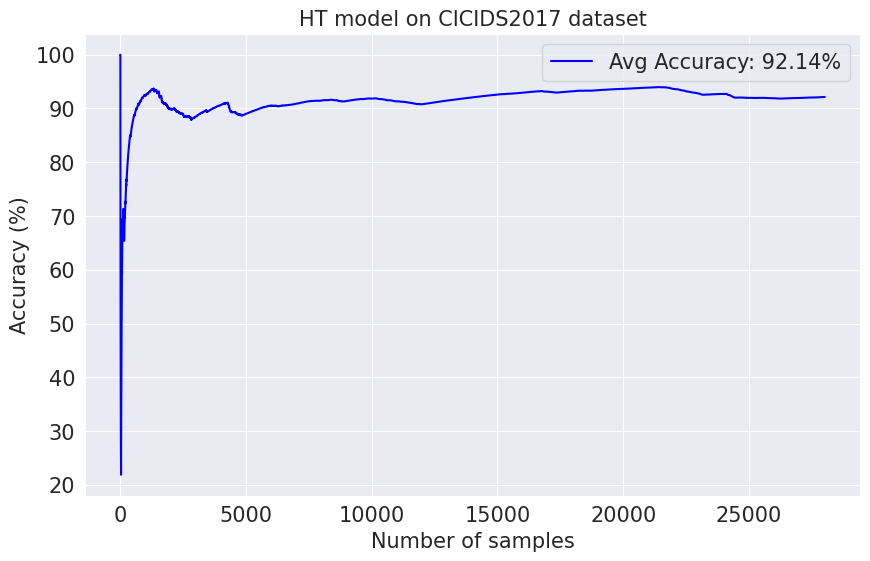

In [ ]:
%%time
# Use the Hoeffding Tree (HT) model
name1 = "HT model"
model1 = tree.HoeffdingTreeClassifier() # Define the model
t, m1 = adaptive_learning(model1, X_train, y_train, X_test, y_test) # Learn the model on the dataset
acc_fig(t, m1, name1)

Accuracy: 98.348%
Precision: 96.654%
Recall: 94.926%
F1-score: 95.782%
CPU times: user 1min 20s, sys: 705 ms, total: 1min 20s
Wall time: 1min 33s


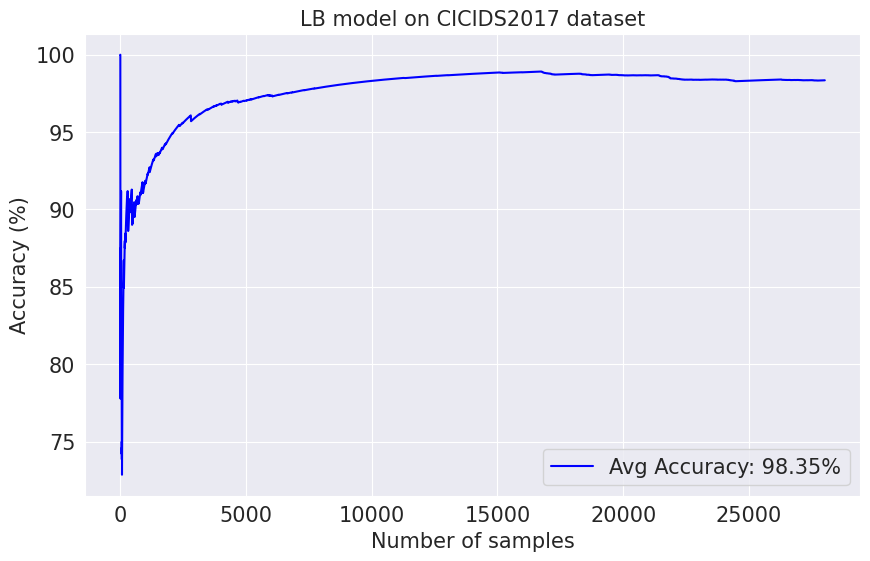

In [ ]:
%%time
# Use the Leveraging Bagging (LB) model
name2 = "LB model"
model2 = ensemble.LeveragingBaggingClassifier(model=tree.HoeffdingTreeClassifier(),n_models=3) # Define the model
t, m2 = adaptive_learning(model2, X_train, y_train, X_test, y_test) # Learn the model on the dataset
acc_fig(t, m2, name2) # Draw the figure of how the real-time accuracy changes with the number of samples

In [ ]:
from river import ensemble

In [ ]:
!pip install --upgrade river

Accuracy: 98.854%
Precision: 98.101%
Recall: 96.06400000000001%
F1-score: 97.071%
CPU times: user 1min 13s, sys: 1.07 s, total: 1min 14s
Wall time: 1min 30s


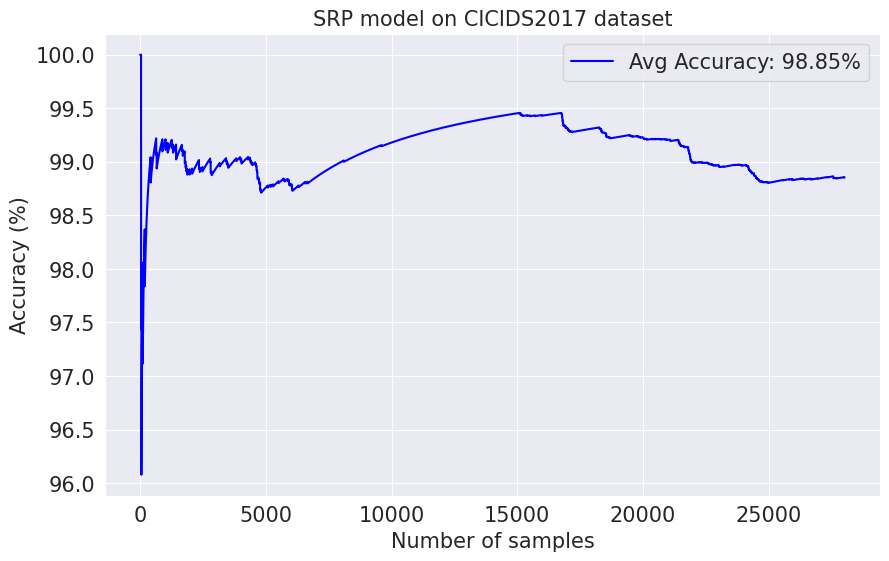

In [ ]:
%%time
# Use the Streaming Random Patches (SRP) model with ADWIN drift detector
name4 = "SRP model"
model4 = ensemble.SRPClassifier(n_models = 3) # Define the model
t, m4 = adaptive_learning(model4, X_train, y_train, X_test, y_test) # Learn the model on the dataset
acc_fig(t, m4, name4) # Draw the figure of how the real-time accuracy changes with the number of samples

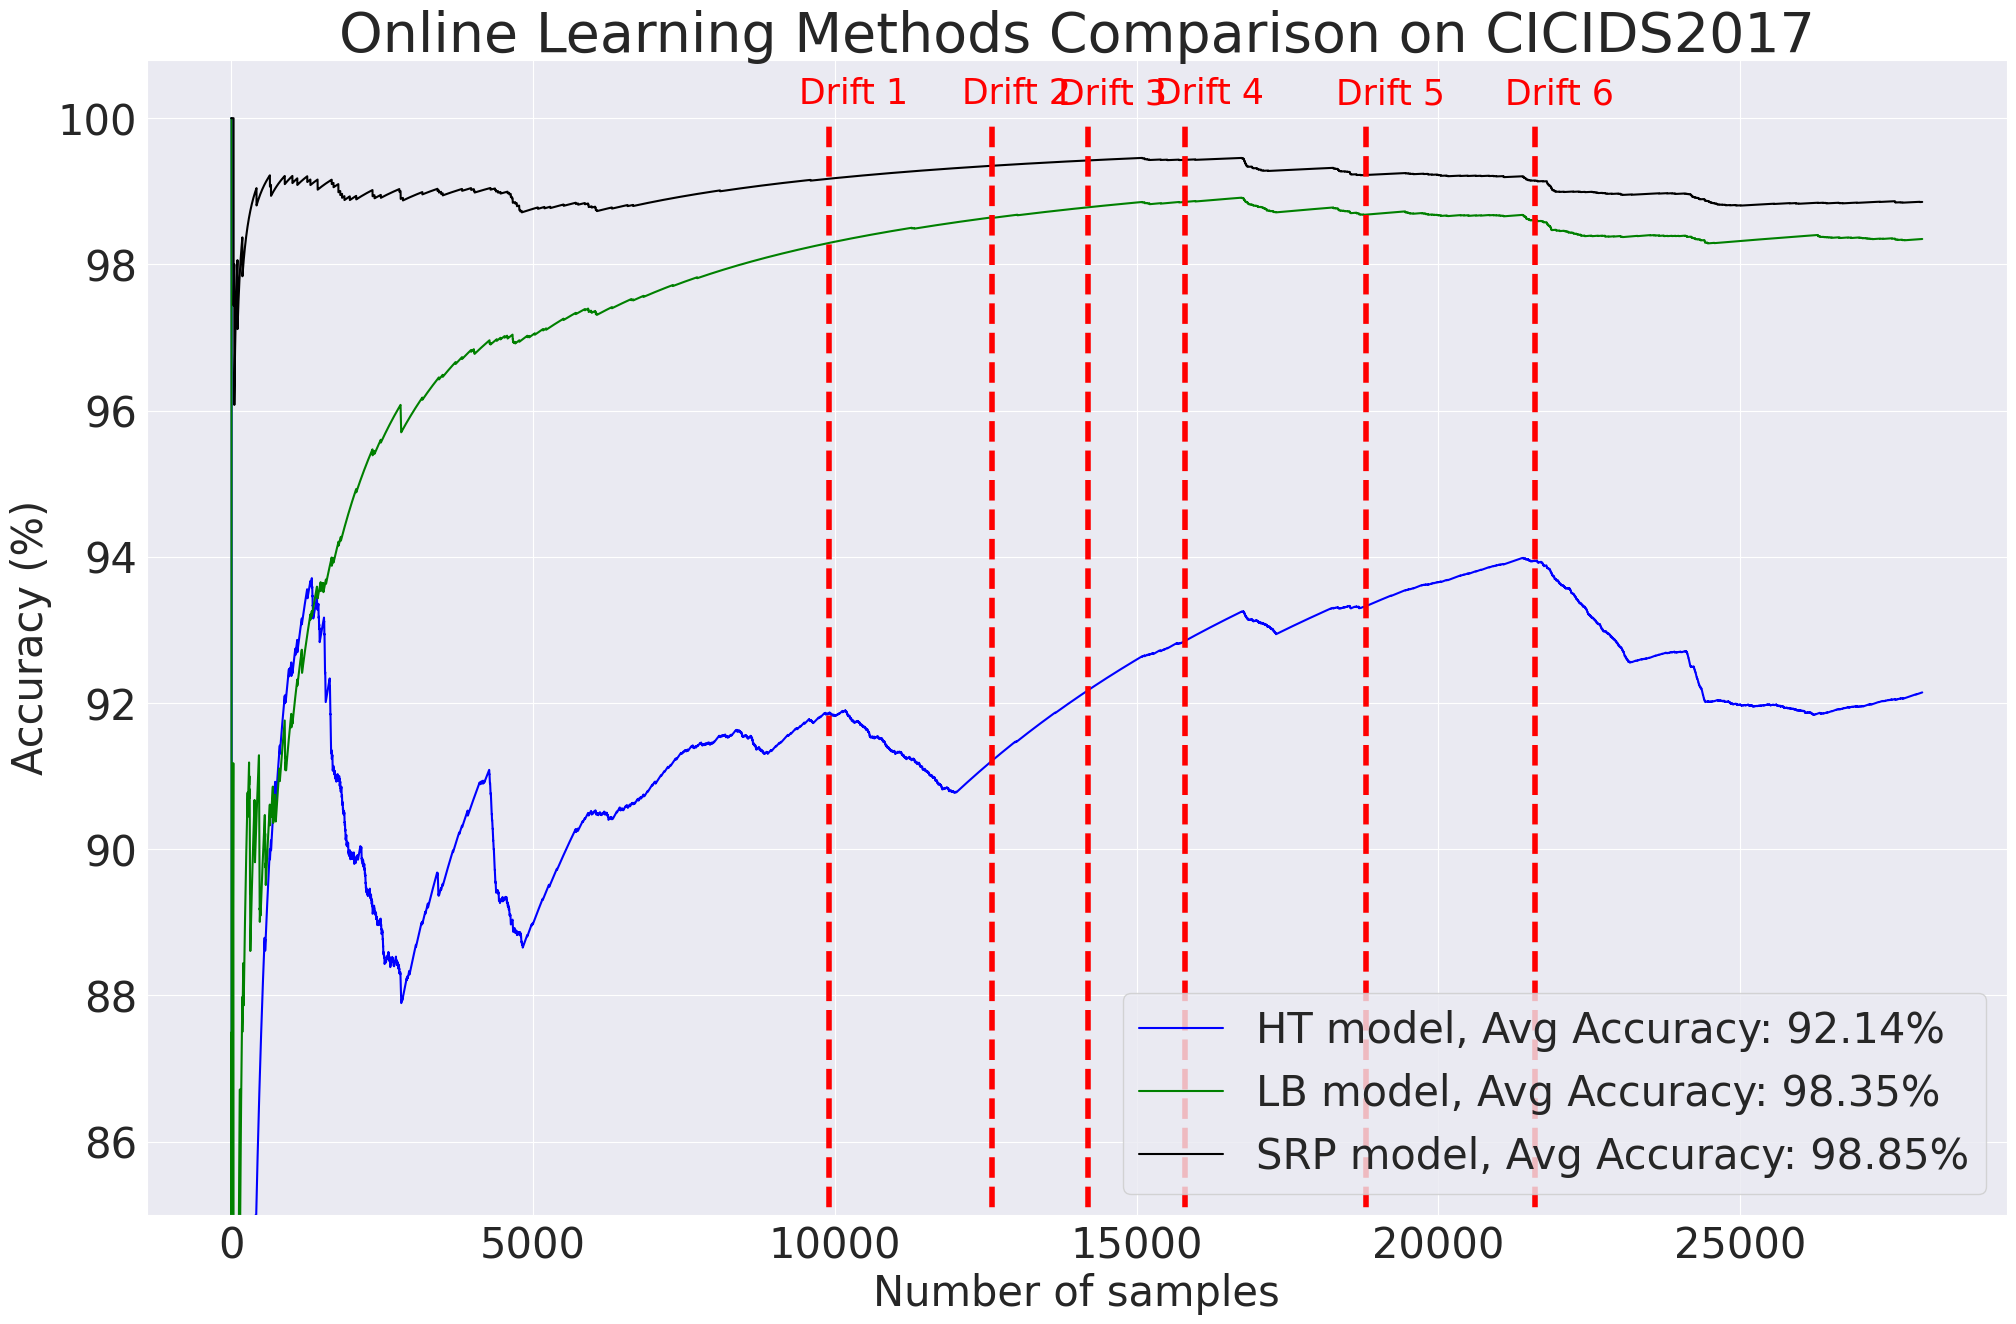

In [ ]:
# Draw a comprehensive figure to compare the performance of all models
plt.rcParams.update({'font.size': 30})
plt.figure(1,figsize=(24,15))
sns.set_style("darkgrid")
plt.clf()

# Plot the accuracy change of each learner
plt.plot(t,m1,'-b',label=name1+', Avg Accuracy: %.2f%%'%(m1[-1]))
plt.plot(t,m2,'-g',label=name2+', Avg Accuracy: %.2f%%'%(m2[-1]))
#plt.plot(t,m3,'orange',label=name3+', Avg Accuracy: %.2f%%'%(m3[-1]))
plt.plot(t,m4,'black',label=name4+', Avg Accuracy: %.2f%%'%(m4[-1]))

# Draw the drift points/time
dr = [0,9900,12600, 14200,15800,18800,21600]
for i in range(len(dr)):
    if i!=0:
        plt.text(dr[i]-500, 100.2, 'Drift '+str(i), c = "red", fontsize = 25)
        plt.vlines(dr[i], 0, 100, colors = "red", linewidth=4, linestyles = "dashed")

plt.legend(loc='lower right')
plt.ylim(85, 100.8)
plt.title('Online Learning Methods Comparison on CICIDS2017', fontsize=40)
plt.xlabel('Number of samples')
plt.ylabel('Accuracy (%)')

plt.draw()

## Automated Online Learning Model Selection

Select the best-performing model among four state-of-the-art online learning models (HT, LB, ARF, and SRP) by evaluating their learning performance

In [ ]:
# Define a generic adaptive learning function
# The argument "model" means an online adaptive learning algorithm
def adaptive_learning_model_selection(model_list, X_train, y_train, X_test, y_test):
    metric = metrics.Accuracy() # Use accuracy as the metric
    i = 0 # count the number of evaluated data points
    t = [] # record the number of evaluated data points
    m = [] # record the real-time accuracy
    yt = [] # record all the true labels of the test set
    yp = [] # record all the predicted labels of the test set
    ypb = [] # record all the predicted labels of the test set for the best performing model
    acc_b = 0 # The best accuracy score
    mb = [] # record the real-time accuracy of the best performing model

    for model in model_list:
        # Learn the training set
        for xi1, yi1 in stream.iter_pandas(X_train, y_train):
            model.learn_one(xi1,yi1)

        # Predict the test set
        for xi, yi in stream.iter_pandas(X_test, y_test):
            y_pred= model.predict_one(xi)  # Predict the test sample
            model.learn_one(xi,yi) # Learn the test sample
            metric = metric.update(yi, y_pred) # Update the real-time accuracy
            t.append(i)
            m.append(metric.get()*100)
            yt.append(yi)
            yp.append(y_pred)
            i = i+1
#         print(accuracy_score(yt,yp))
        if accuracy_score(yt,yp)>acc_b:
            acc_b = accuracy_score(yt,yp)
            mb = m
            ypb = yp
            model_b = model

    print(model_b)
    print("Accuracy: "+str(round(accuracy_score(yt,ypb),5)*100)+"%")
    print("Precision: "+str(round(precision_score(yt,ypb),5)*100)+"%")
    print("Recall: "+str(round(recall_score(yt,ypb),5)*100)+"%")
    print("F1-score: "+str(round(f1_score(yt,ypb),5)*100)+"%")
    return t, mb

SRP with the highest accuracy is selected as the best/most suitable online learner

# 4. Hyperparameter Optimization
Optimize the best performing online learning model (SRP) by tuning its hyperparameters

In [ ]:
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
from sklearn.model_selection import cross_val_score, StratifiedKFold

# Define the objective function
def objective(params):
    params = {
        'n_models': int(params['n_models']),
        'subspace_size': abs(float(params['subspace_size'])),
    }
    clf = ensemble.SRPClassifier( **params)

    t, m = adaptive_learning(clf, X_train, y_train, X_test, y_test)

    return {'loss':-m[-1], 'status': STATUS_OK }

# Define the hyperparameter configuration space
space = {
    'n_models': hp.quniform('n_models', 2, 10, 1),
    "subspace_size":hp.uniform('subspace_size', 0.3, 1),
}

# Detect the optimal hyperparameter values
best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=10)
print("SRP: Hyperopt estimated optimum {}".format(best))

'from hyperopt import hp, fmin, tpe, STATUS_OK, Trials\nfrom sklearn.model_selection import cross_val_score, StratifiedKFold\n\n# Define the objective function\ndef objective(params):\n    params = {\n        \'n_models\': int(params[\'n_models\']),\n        \'subspace_size\': abs(float(params[\'subspace_size\'])),\n    }\n    clf = ensemble.SRPClassifier( **params)\n\n    t, m = adaptive_learning(clf, X_train, y_train, X_test, y_test)\n\n    return {\'loss\':-m[-1], \'status\': STATUS_OK }\n\n# Define the hyperparameter configuration space\nspace = {\n    \'n_models\': hp.quniform(\'n_models\', 2, 10, 1),\n    "subspace_size":hp.uniform(\'subspace_size\', 0.3, 1),\n}\n\n# Detect the optimal hyperparameter values\nbest = fmin(fn=objective,\n            space=space,\n            algo=tpe.suggest,\n            max_evals=10)\nprint("SRP: Hyperopt estimated optimum {}".format(best))'

After hyperparameter optimization, the accuracy of SRP has been improved from 97.392% to 99.841%

In [ ]:
import pickle

# Save the trained classifier model
with open('ids_online_model.pkl', 'wb') as f:
    pickle.dump(model4,f)




In [ ]:
i=[[0.0003973835088443831,5.9771533737555706e-05,0.001732473811442385,0.01115091957415828,0.005072214580467675,0.0004415370206838141,0.0004415370206838141,0.0,0.0001497370243509836,1.3981516433333333e-05,0.0,0.0]]

with open('ids_online_model.pkl', 'rb') as f:
    ids_online_model = pickle.load(f)

class_labels = ["Normal", "Anamoly"]

predictions = []
for instance in i:
    instance = np.array(instance)
    prediction = ids_online_model.predict_proba_one(instance)
    predicted_class = max(prediction, key=prediction.get)
    predictions.append(predicted_class)

for prediction in predictions:
  print(prediction)
  class_label = class_labels[prediction]
  print(class_label)


0
Normal


In [ ]:
import os
import time
import pickle
import smtplib
from email.mime.text import MIMEText
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import lightgbm as lgb
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from scipy.stats import shapiro
from imblearn.over_sampling import SMOTE
import warnings
warnings.filterwarnings('ignore')


In [ ]:
import pickle
import smtplib
from email.mime.multipart import MIMEMultipart
from email.mime.text import MIMEText

# Function to send an email alert
def send_email_alert(subject, body, from_addr, to_addr, smtp_server, port, username, password):
    msg = MIMEMultipart()
    msg['From'] = from_addr
    msg['To'] = to_addr
    msg['Subject'] = subject
    msg.attach(MIMEText(body, 'plain'))

    server = smtplib.SMTP(smtp_server, port)
    server.starttls()
    server.login(username, password)
    text = msg.as_string()
    server.sendmail(from_addr, to_addr, text)
    server.quit()

# Load the trained classifier model
with open('ids_online_model.pkl', 'rb') as f:
    ids_online_model = pickle.load(f)

class_labels = ["Normal", "Anamoly"]

# List of instances to predict
instances = [
    [[0.0003973835088443831, 5.9771533737555706e-05, 0.001732473811442385, 0.01115091957415828, 0.005072214580467675, 0.0004415370206838141, 0.0004415370206838141, 0.0, 0.0001497370243509836, 1.3981516433333333e-05, 0.0, 0.0]],
    # Add more instances as needed
]

predictions = []

for instance in instances:
    instance = np.array(instance)
    prediction = ids_online_model.predict_proba_one(instance)
    predicted_class = max(prediction, key=prediction.get)
    predictions.append(predicted_class)

    # Check if the predicted class indicates an anomaly
    if class_labels[predicted_class] == "Anamoly":
        # Prepare and send an email alert
        subject = "Anomaly Detected"
        body = "An anomaly has been detected in the system. Please investigate."
        from_addr = "deekshu0004@gmail.com"
        to_addr = "itsyou3004@gmail.com"
        smtp_server = "smtp.example.com"
        port = 587
        username = "Deekshitha"
        password = "abcdef"

        send_email_alert(subject, body, from_addr, to_addr, smtp_server, port, username, password)
        print("Email alert sent for anomaly detection.")


In [ ]:
pip install slack-sdk


In [ ]:
from slack_sdk import WebClient
from slack_sdk.errors import SlackApiError

def send_slack_alert(text, token, channel_id):
    client = WebClient(token=token)
    try:
        response = client.chat_postMessage(
            channel=channel_id,
            text=text
        )
    except SlackApiError as e:
        print(f"Error sending message: {e.response['error']}")

# Example usage
text = "An anomaly has been detected in the system. Please investigate."
token = "your_slack_bot_token"
channel_id = "C12345678"  # Replace with your channel ID

send_slack_alert(text, token, channel_id)


In [ ]:
def send_alert(subject, message):
    sender_email = "gmeghana0408@gmail.com"
    receiver_email = "deekshu0004@gmail.com"
    password = "abcdef"

    msg = MIMEText(message)
    msg['Subject'] = subject
    msg['From'] = sender_email
    msg['To'] = receiver_email

    try:
        server = smtplib.SMTP('smtp.gmail.com', 587)  # Replace with your SMTP server details
        server.starttls()
        server.login(sender_email, password)
        server.sendmail(sender_email, receiver_email, msg.as_string())
        server.quit()
        print("Email sent!")
    except Exception as e:
        print(f"Failed to send email: {e}")


In [ ]:
with open('/content/ids_online_model.pkl', 'rb') as f:
    ids_online_model = pickle.load(f)

df = pd.read_csv("/content/cic_0.01km.csv")
df.columns=['Flow Duration', 'Total Length of Fwd Packets', 'Fwd Packet Length Max',
       'Fwd Packet Length Mean', 'Bwd Packet Length Max',
       'Bwd Packet Length Min', 'Flow IAT Mean', 'Flow IAT Min', 'Fwd IAT Min',
       'Fwd Header Length', 'Bwd Header Length', 'Fwd Packets/s',
       'Bwd Packets/s', 'Min Packet Length', 'URG Flag Count', 'Down/Up Ratio',
       'Init_Win_bytes_forward', 'Init_Win_bytes_backward',
       'min_seg_size_forward', 'Label']

def Auto_Encoding(df):
    cat_features = [x for x in df.columns if df[x].dtype == "object"]
    le = LabelEncoder()
    for col in cat_features:
        if col in df.columns:
            i = df.columns.get_loc(col)
            df.iloc[:, i] = df.apply(lambda i: le.fit_transform(i.astype(str)), axis=0, result_type='expand')
    return df

def Auto_Imputation(df):
    if df.isnull().values.any() or np.isinf(df).values.any():
        df.replace([np.inf, -np.inf], np.nan, inplace=True)
        df.fillna(0, inplace=True)
    return df

df = Auto_Encoding(df)
df = Auto_Imputation(df)


In [ ]:
# Function to preprocess new data and make predictions
def process_and_predict(new_data):
    predictions = []
    for _, row in new_data.iterrows():
        # Convert the row to a dictionary format expected by predict_one or predict_proba_one
        row_dict = row.to_dict()
        prediction = ids_online_model.predict_one(row_dict)  # Use predict_one
        predictions.append(prediction)
    return predictions


import os

# Specify your desired directory path
watch_dir = '/content/data/new_data'

# Check if watch_dir exists, create it if not
if not os.path.exists(watch_dir):
    os.makedirs(watch_dir)
    print(f"Directory {watch_dir} created.")

# Now you can proceed with the main script logic
while True:
    #time.sleep(60)  # Check for new data every 60 seconds

    files = os.listdir(watch_dir)

    for file in files:
        if file.endswith('.csv'):
            file_path = os.path.join(watch_dir, file)
            new_data = pd.read_csv("output_data.csv")
            new_data = Auto_Encoding(new_data)
            new_data = Auto_Imputation(new_data)

            prediction = process_and_predict(new_data)

            if 1 in prediction:  # Assuming 1 represents an anomaly
                subject = "Anomaly Detected!"
                message = f"An anomaly has been detected in the file: {file}"
                send_alert(subject, message)

                # Optionally, delete the processed file after sending the alert
                os.remove(file_path)


Directory /content/data/new_data created.
